In [ ]:
import scipy.io
import h5py
import numpy as np
import tensorflow as tf 
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
from keras.layers import Input, Dense, ZeroPadding2D, Dropout, Activation, Flatten, Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, concatenate, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

#Prepare Preprocessed Dataset

In [ ]:
file = h5py.File('DB1_S1.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]  
file.close()

In [ ]:
print(imageData.shape)
print(imageLabel.shape)

(15047, 12, 10)
(15047,)


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
# prepare data
n = imageData.shape[0]
idx = np.random.permutation(n)
data  = imageData[idx]
label = imageLabel[idx]

data  = np.expand_dims(data, axis=3)
label = convert_to_one_hot(label, 52).T

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size = 0.2, random_state = 42)

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (12037, 12, 10, 1)
Y_train shape: (12037, 52)
X_test shape: (3010, 12, 10, 1)
Y_test shape: (3010, 52)


In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'epoch':[]}
        self.accuracy = {'epoch':[]}
        self.val_loss = {'epoch':[]}
        self.val_acc = {'epoch':[]}

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
        plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [ ]:
eps = 200

# CNN

In [ ]:
def CNN(input_shape, classes): 
    X_input = Input(input_shape)
    
    X = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name='conv1')(X_input)
    X = Activation('relu', name='relu1')(X)

    X = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name='conv2')(X)
    X = Activation('relu', name='relu2')(X)
    X = AveragePooling2D((3,3), strides=(2,2), name='pool1')(X)
    
    X = Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),padding='same', name='conv3')(X)
    X = Activation('relu', name='relu3')(X)
    X = AveragePooling2D((3,3), strides=(2,2), name='pool2')(X)

    X = Conv2D(filters=64, kernel_size=(5,1), strides=(1,1),padding='same', name='conv4')(X)
    X = Activation('relu', name='relu4')(X)

    X = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1),padding='same', name='conv5')(X)
    
    X = ZeroPadding2D((0,1))(X)

    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization(momentum=0.9)(X)
    X = Dense(128, activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    
    model = Model(inputs=X_input, outputs=X, name='CNN')
    return model

In [ ]:
model = CNN(input_shape = (12, 10, 1), classes = 52)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 12, 10, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 12, 10, 32)        320       
                                                                 
 relu1 (Activation)          (None, 12, 10, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 12, 10, 32)        9248      
                                                                 
 relu2 (Activation)          (None, 12, 10, 32)        0         
                                                                 
 pool1 (AveragePooling2D)    (None, 5, 4, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 5, 4, 64)          51264   

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = LossHistory()

model.fit(data, label, validation_split=0.2, epochs=eps, batch_size=256, verbose=1, callbacks=[history])

print('-------------------------------------------------------------------------')
preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))

Epoch 1/200
48/48 [==============================] - 2s 14ms/step - loss: 3.8183 - accuracy: 0.0493 - val_loss: 3.6450 - val_accuracy: 0.1086
Epoch 2/200
48/48 [==============================] - 0s 10ms/step - loss: 3.3999 - accuracy: 0.1135 - val_loss: 3.0265 - val_accuracy: 0.1874
Epoch 3/200
48/48 [==============================] - 0s 10ms/step - loss: 3.0634 - accuracy: 0.1711 - val_loss: 2.6854 - val_accuracy: 0.2870
Epoch 4/200
48/48 [==============================] - 0s 9ms/step - loss: 2.8048 - accuracy: 0.2391 - val_loss: 2.6454 - val_accuracy: 0.2844
Epoch 5/200
48/48 [==============================] - 0s 9ms/step - loss: 2.6393 - accuracy: 0.2761 - val_loss: 2.2548 - val_accuracy: 0.3877
Epoch 6/200
48/48 [==============================] - 0s 9ms/step - loss: 2.5147 - accuracy: 0.3064 - val_loss: 2.1249 - val_accuracy: 0.4183
Epoch 7/200
48/48 [==============================] - 0s 10ms/step - loss: 2.3240 - accuracy: 0.3562 - val_loss: 2.0074 - val_accuracy: 0.4545
Epoch 8/2

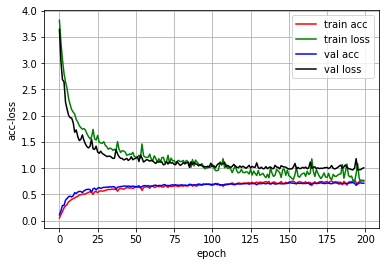

In [ ]:
history.loss_plot('epoch')

# Mario CNN

In [ ]:
def Mario_CNN(input_shape, classes): 
    X_input = Input(input_shape)

    # Mario Brothers Split
    X1, X2 = tf.split(X_input, 2, 2)
    
    # Architecture 1
    X1 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name='A1_conv1')(X1)
    X1 = Activation('relu', name='A1_relu1')(X1)

    X1 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name='A1_conv2')(X1)
    X1 = Activation('relu', name='A1_relu2')(X1)
    X1 = MaxPooling2D((1,2), strides=(2,2), name='A1_pool1')(X1)
    
    X1 = Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),padding='same', name='A1_conv3')(X1)
    X1 = Activation('relu', name='A1_relu3')(X1)
    X1 = MaxPooling2D((1,2), strides=(2,2), name='A1_pool2')(X1)

    X1 = Conv2D(filters=64, kernel_size=(5,1), strides=(1,1),padding='same', name='A1_conv4')(X1)
    X1 = Activation('relu', name='A1_relu4')(X1)

    X1 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1),padding='same', name='A1_conv5')(X1)

    # Architecture 2
    X2 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name='A2_conv1')(X2)
    X2 = Activation('relu', name='A2_relu1')(X2)

    X2 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name='A2_conv2')(X2)
    X2 = Activation('relu', name='A2_relu2')(X2)
    X2 = MaxPooling2D((1,2), strides=(2,2), name='A2_pool1')(X2)
    
    X2 = Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),padding='same', name='A2_conv3')(X2)
    X2 = Activation('relu', name='A2_relu3')(X2)
    X2 = MaxPooling2D((1,2), strides=(2,2), name='A2_pool2')(X2)

    X2 = Conv2D(filters=64, kernel_size=(5,1), strides=(1,1),padding='same', name='A2_conv4')(X2)
    X2 = Activation('relu', name='A2_relu4')(X2)

    X2 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1),padding='same', name='A2_conv5')(X2)
    
    # Mario Brothers Reunion
    X = tf.keras.layers.Concatenate(axis=2)([X1, X2])

    X = ZeroPadding2D((0,1))(X)
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization(momentum=0.9)(X)
    X = Dense(128, activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X, name='MarioCNN')

    return model

In [ ]:
model = Mario_CNN(input_shape = (12, 10, 1), classes = 52)
model.summary()

Model: "MarioCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 12, 10, 1)]  0           []                               
                                                                                                  
 tf.split_11 (TFOpLambda)       [(None, 12, 5, 1),   0           ['input_14[0][0]']               
                                 (None, 12, 5, 1)]                                                
                                                                                                  
 A1_conv1 (Conv2D)              (None, 12, 5, 32)    320         ['tf.split_11[0][0]']            
                                                                                                  
 A2_conv1 (Conv2D)              (None, 12, 5, 32)    320         ['tf.split_11[0][1]']     

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = LossHistory()

model.fit(data, label, validation_split=0.2, epochs=eps, batch_size=256, verbose=1, callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))

Epoch 1/200
48/48 [==============================] - 3s 20ms/step - loss: 3.7016 - accuracy: 0.0733 - val_loss: 3.4866 - val_accuracy: 0.1977
Epoch 2/200
48/48 [==============================] - 1s 12ms/step - loss: 3.1249 - accuracy: 0.1841 - val_loss: 2.5681 - val_accuracy: 0.3492
Epoch 3/200
48/48 [==============================] - 1s 12ms/step - loss: 2.7087 - accuracy: 0.2745 - val_loss: 2.2832 - val_accuracy: 0.4063
Epoch 4/200
48/48 [==============================] - 1s 13ms/step - loss: 2.4489 - accuracy: 0.3311 - val_loss: 1.9895 - val_accuracy: 0.4555
Epoch 5/200
48/48 [==============================] - 1s 13ms/step - loss: 2.2539 - accuracy: 0.3808 - val_loss: 1.8192 - val_accuracy: 0.4977
Epoch 6/200
48/48 [==============================] - 1s 12ms/step - loss: 2.0780 - accuracy: 0.4172 - val_loss: 1.7143 - val_accuracy: 0.5279
Epoch 7/200
48/48 [==============================] - 1s 12ms/step - loss: 1.9774 - accuracy: 0.4391 - val_loss: 1.5806 - val_accuracy: 0.5502
Epoch 

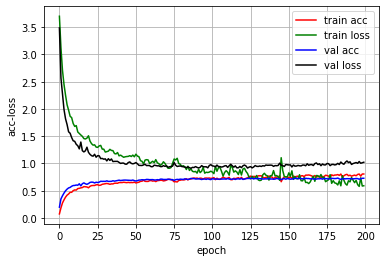

In [ ]:
history.loss_plot('epoch')

In [ ]:
dic = {}
dic[1] = 1
dic[2] = 2
dic[3] = [3, 3, 4]
dic[4] = [2, 2, 3, 3]
dic[5] = 5
dic[6] = [1, 1, 2, 2, 2, 2]
dic[7] = [1, 1, 1, 1, 2, 2, 2]
dic[8] = [1, 1, 1, 1, 1, 1, 2, 2]
dic[9] = [1, 1, 1, 1, 1, 1, 1, 1, 2]
dic[10] = 10

def Mario_CNN_plus(input_shape, classes, n_of_streams, dic): 
    X_input = Input(input_shape)
    split_rules = dic[n_of_streams]

    # Mario Brothers Split
    Xs1 = tf.split(X_input, split_rules, 2)
    Xs2 = []
    i = 0

    # Multiple Streams
    for X in Xs1:
      i += 1
      X = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name= (str(i) + '_conv1'))(X)
      X = Activation('relu', name=(str(i) + '_relu1'))(X)

      X = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name=(str(i) + '_conv2'))(X)
      X = Activation('relu', name=(str(i) + '_relu2'))(X)
      X = MaxPooling2D((1,1), strides=(1,1), name=(str(i) + '_pool1'))(X)
      
      X = Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),padding='same', name=(str(i) + '_conv3'))(X)
      X = Activation('relu', name=(str(i) + '_relu3'))(X)
      X = MaxPooling2D((1,1), strides=(1,1), name=(str(i) + '_pool2'))(X)

      X = Conv2D(filters=64, kernel_size=(5,1), strides=(1,1),padding='same', name=(str(i) + '_conv4'))(X)
      X = Activation('relu', name=(str(i) + '_relu4'))(X)

      X = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1),padding='same', name=(str(i) + '_conv5'))(X)
    
      Xs2.append(X)

    # Mario Brothers Reunion
    X = tf.keras.layers.Concatenate(axis=2)(Xs2)

    X = ZeroPadding2D((0,1))(X)
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization(momentum=0.9)(X)
    X = Dense(128, activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X, name='MarioCNN')

    return model

Epoch 1/200
48/48 [==============================] - 2s 17ms/step - loss: 3.1433 - accuracy: 0.2055 - val_loss: 2.8707 - val_accuracy: 0.4272
Epoch 2/200
48/48 [==============================] - 1s 11ms/step - loss: 2.2837 - accuracy: 0.3889 - val_loss: 1.7412 - val_accuracy: 0.5385
Epoch 3/200
48/48 [==============================] - 1s 12ms/step - loss: 1.9426 - accuracy: 0.4661 - val_loss: 1.5460 - val_accuracy: 0.5591
Epoch 4/200
48/48 [==============================] - 1s 12ms/step - loss: 1.8146 - accuracy: 0.4993 - val_loss: 1.3942 - val_accuracy: 0.6126
Epoch 5/200
48/48 [==============================] - 1s 11ms/step - loss: 1.6161 - accuracy: 0.5427 - val_loss: 1.2678 - val_accuracy: 0.6355
Epoch 6/200
48/48 [==============================] - 1s 11ms/step - loss: 1.5650 - accuracy: 0.5556 - val_loss: 1.2482 - val_accuracy: 0.6422
Epoch 7/200
48/48 [==============================] - 1s 12ms/step - loss: 1.4991 - accuracy: 0.5650 - val_loss: 1.1741 - val_accuracy: 0.6518
Epoch 

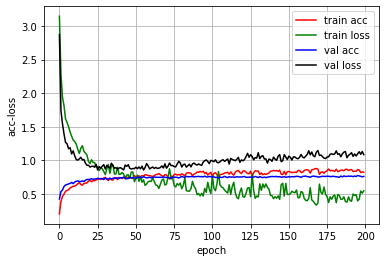

Epoch 1/200
48/48 [==============================] - 2s 21ms/step - loss: 3.1560 - accuracy: 0.2051 - val_loss: 2.9409 - val_accuracy: 0.4063
Epoch 2/200
48/48 [==============================] - 1s 14ms/step - loss: 2.3694 - accuracy: 0.3730 - val_loss: 1.8365 - val_accuracy: 0.5090
Epoch 3/200
48/48 [==============================] - 1s 14ms/step - loss: 2.0452 - accuracy: 0.4373 - val_loss: 1.6297 - val_accuracy: 0.5442
Epoch 4/200
48/48 [==============================] - 1s 14ms/step - loss: 1.8277 - accuracy: 0.4925 - val_loss: 1.4187 - val_accuracy: 0.5953
Epoch 5/200
48/48 [==============================] - 1s 15ms/step - loss: 1.7272 - accuracy: 0.5078 - val_loss: 1.3334 - val_accuracy: 0.6163
Epoch 6/200
48/48 [==============================] - 1s 15ms/step - loss: 1.5956 - accuracy: 0.5490 - val_loss: 1.3191 - val_accuracy: 0.6126
Epoch 7/200
48/48 [==============================] - 1s 17ms/step - loss: 1.5614 - accuracy: 0.5517 - val_loss: 1.2541 - val_accuracy: 0.6372
Epoch 

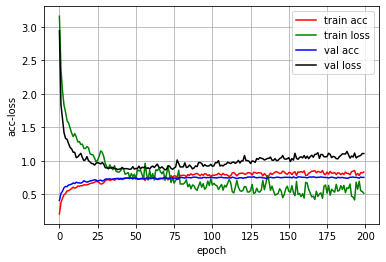

Epoch 1/200
48/48 [==============================] - 3s 25ms/step - loss: 3.1566 - accuracy: 0.2011 - val_loss: 2.9236 - val_accuracy: 0.4219
Epoch 2/200
48/48 [==============================] - 1s 20ms/step - loss: 2.3441 - accuracy: 0.3759 - val_loss: 1.7802 - val_accuracy: 0.5243
Epoch 3/200
48/48 [==============================] - 1s 17ms/step - loss: 2.0480 - accuracy: 0.4381 - val_loss: 1.5929 - val_accuracy: 0.5615
Epoch 4/200
48/48 [==============================] - 1s 17ms/step - loss: 1.9082 - accuracy: 0.4673 - val_loss: 1.4489 - val_accuracy: 0.5864
Epoch 5/200
48/48 [==============================] - 1s 19ms/step - loss: 1.7428 - accuracy: 0.5120 - val_loss: 1.3484 - val_accuracy: 0.5983
Epoch 6/200
48/48 [==============================] - 1s 18ms/step - loss: 1.6288 - accuracy: 0.5334 - val_loss: 1.2485 - val_accuracy: 0.6272
Epoch 7/200
48/48 [==============================] - 1s 17ms/step - loss: 1.5155 - accuracy: 0.5665 - val_loss: 1.2312 - val_accuracy: 0.6339
Epoch 

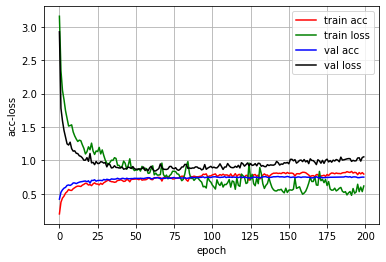

Epoch 1/200
48/48 [==============================] - 3s 28ms/step - loss: 3.2738 - accuracy: 0.1749 - val_loss: 3.0966 - val_accuracy: 0.3505
Epoch 2/200
48/48 [==============================] - 1s 20ms/step - loss: 2.4820 - accuracy: 0.3383 - val_loss: 1.9171 - val_accuracy: 0.4801
Epoch 3/200
48/48 [==============================] - 1s 22ms/step - loss: 2.1100 - accuracy: 0.4265 - val_loss: 1.5894 - val_accuracy: 0.5588
Epoch 4/200
48/48 [==============================] - 1s 21ms/step - loss: 1.9227 - accuracy: 0.4674 - val_loss: 1.6026 - val_accuracy: 0.5488
Epoch 5/200
48/48 [==============================] - 1s 22ms/step - loss: 1.8441 - accuracy: 0.4831 - val_loss: 1.4102 - val_accuracy: 0.5940
Epoch 6/200
48/48 [==============================] - 1s 22ms/step - loss: 1.7222 - accuracy: 0.5084 - val_loss: 1.3946 - val_accuracy: 0.5834
Epoch 7/200
48/48 [==============================] - 1s 23ms/step - loss: 1.6647 - accuracy: 0.5192 - val_loss: 1.4241 - val_accuracy: 0.5907
Epoch 

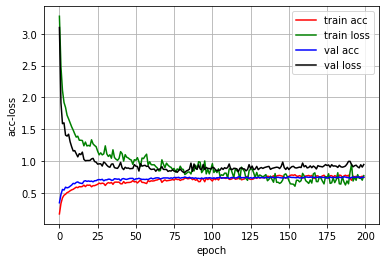

Epoch 1/200
48/48 [==============================] - 4s 33ms/step - loss: 3.2231 - accuracy: 0.1832 - val_loss: 2.9858 - val_accuracy: 0.3684
Epoch 2/200
48/48 [==============================] - 1s 24ms/step - loss: 2.4425 - accuracy: 0.3480 - val_loss: 1.9366 - val_accuracy: 0.4754
Epoch 3/200
48/48 [==============================] - 1s 23ms/step - loss: 2.1433 - accuracy: 0.4111 - val_loss: 1.6823 - val_accuracy: 0.5322
Epoch 4/200
48/48 [==============================] - 1s 23ms/step - loss: 1.9638 - accuracy: 0.4502 - val_loss: 1.5624 - val_accuracy: 0.5568
Epoch 5/200
48/48 [==============================] - 1s 23ms/step - loss: 1.8005 - accuracy: 0.4917 - val_loss: 1.4539 - val_accuracy: 0.5897
Epoch 6/200
48/48 [==============================] - 1s 25ms/step - loss: 1.7271 - accuracy: 0.5050 - val_loss: 1.3359 - val_accuracy: 0.6103
Epoch 7/200
48/48 [==============================] - 1s 24ms/step - loss: 1.6553 - accuracy: 0.5263 - val_loss: 1.2681 - val_accuracy: 0.6266
Epoch 

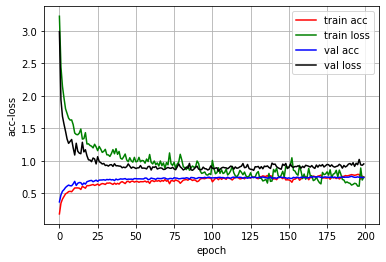

Epoch 1/200
48/48 [==============================] - 5s 48ms/step - loss: 3.2696 - accuracy: 0.1813 - val_loss: 3.0112 - val_accuracy: 0.4063
Epoch 2/200
48/48 [==============================] - 1s 27ms/step - loss: 2.4621 - accuracy: 0.3482 - val_loss: 1.9885 - val_accuracy: 0.4641
Epoch 3/200
48/48 [==============================] - 1s 28ms/step - loss: 2.1716 - accuracy: 0.4042 - val_loss: 1.7272 - val_accuracy: 0.5143
Epoch 4/200
48/48 [==============================] - 1s 30ms/step - loss: 1.9775 - accuracy: 0.4499 - val_loss: 1.5459 - val_accuracy: 0.5631
Epoch 5/200
48/48 [==============================] - 1s 30ms/step - loss: 1.8410 - accuracy: 0.4815 - val_loss: 1.4677 - val_accuracy: 0.5811
Epoch 6/200
48/48 [==============================] - 1s 28ms/step - loss: 1.7391 - accuracy: 0.5096 - val_loss: 1.3651 - val_accuracy: 0.6027
Epoch 7/200
48/48 [==============================] - 1s 28ms/step - loss: 1.6331 - accuracy: 0.5318 - val_loss: 1.3130 - val_accuracy: 0.6133
Epoch 

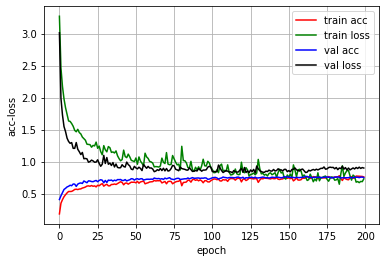

Epoch 1/200
48/48 [==============================] - 5s 43ms/step - loss: 3.2925 - accuracy: 0.1752 - val_loss: 3.0790 - val_accuracy: 0.3571
Epoch 2/200
48/48 [==============================] - 2s 31ms/step - loss: 2.4840 - accuracy: 0.3387 - val_loss: 2.0939 - val_accuracy: 0.4346
Epoch 3/200
48/48 [==============================] - 2s 35ms/step - loss: 2.1979 - accuracy: 0.4001 - val_loss: 1.6857 - val_accuracy: 0.5352
Epoch 4/200
48/48 [==============================] - 2s 32ms/step - loss: 1.9993 - accuracy: 0.4422 - val_loss: 1.5776 - val_accuracy: 0.5465
Epoch 5/200
48/48 [==============================] - 2s 32ms/step - loss: 1.9026 - accuracy: 0.4671 - val_loss: 1.4400 - val_accuracy: 0.5841
Epoch 6/200
48/48 [==============================] - 2s 32ms/step - loss: 1.8138 - accuracy: 0.4908 - val_loss: 1.4307 - val_accuracy: 0.5904
Epoch 7/200
48/48 [==============================] - 2s 33ms/step - loss: 1.7070 - accuracy: 0.5096 - val_loss: 1.2899 - val_accuracy: 0.6213
Epoch 

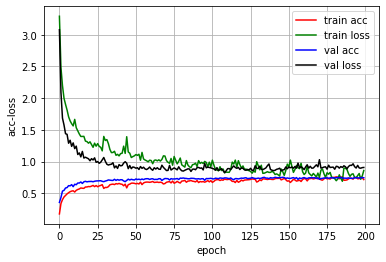

Epoch 1/200
48/48 [==============================] - 5s 47ms/step - loss: 3.2690 - accuracy: 0.1742 - val_loss: 3.0369 - val_accuracy: 0.3635
Epoch 2/200
48/48 [==============================] - 2s 35ms/step - loss: 2.5039 - accuracy: 0.3320 - val_loss: 1.9125 - val_accuracy: 0.4794
Epoch 3/200
48/48 [==============================] - 2s 36ms/step - loss: 2.2050 - accuracy: 0.3876 - val_loss: 1.7402 - val_accuracy: 0.5050
Epoch 4/200
48/48 [==============================] - 2s 35ms/step - loss: 2.0536 - accuracy: 0.4277 - val_loss: 1.6878 - val_accuracy: 0.5123
Epoch 5/200
48/48 [==============================] - 2s 38ms/step - loss: 1.9484 - accuracy: 0.4508 - val_loss: 1.5388 - val_accuracy: 0.5528
Epoch 6/200
48/48 [==============================] - 2s 35ms/step - loss: 1.8767 - accuracy: 0.4716 - val_loss: 1.4686 - val_accuracy: 0.5824
Epoch 7/200
48/48 [==============================] - 2s 38ms/step - loss: 1.7304 - accuracy: 0.5025 - val_loss: 1.3277 - val_accuracy: 0.6146
Epoch 

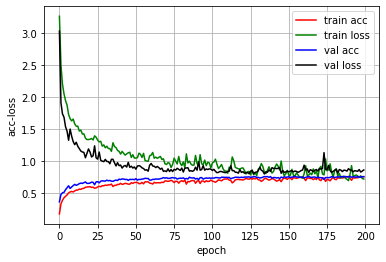

Epoch 1/200
48/48 [==============================] - 6s 53ms/step - loss: 3.2955 - accuracy: 0.1602 - val_loss: 3.1049 - val_accuracy: 0.3040
Epoch 2/200
48/48 [==============================] - 2s 40ms/step - loss: 2.6098 - accuracy: 0.3006 - val_loss: 2.0771 - val_accuracy: 0.4542
Epoch 3/200
48/48 [==============================] - 2s 40ms/step - loss: 2.3087 - accuracy: 0.3725 - val_loss: 1.9767 - val_accuracy: 0.4591
Epoch 4/200
48/48 [==============================] - 2s 39ms/step - loss: 2.1111 - accuracy: 0.4146 - val_loss: 1.7224 - val_accuracy: 0.5060
Epoch 5/200
48/48 [==============================] - 2s 41ms/step - loss: 1.9440 - accuracy: 0.4543 - val_loss: 1.6688 - val_accuracy: 0.5199
Epoch 6/200
48/48 [==============================] - 2s 39ms/step - loss: 1.9110 - accuracy: 0.4557 - val_loss: 1.5296 - val_accuracy: 0.5734
Epoch 7/200
48/48 [==============================] - 2s 39ms/step - loss: 1.7630 - accuracy: 0.4917 - val_loss: 1.3956 - val_accuracy: 0.6013
Epoch 

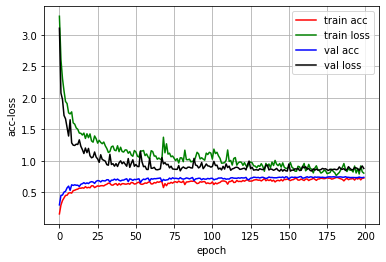

Epoch 1/200
48/48 [==============================] - 7s 59ms/step - loss: 3.3187 - accuracy: 0.1662 - val_loss: 3.1379 - val_accuracy: 0.3385
Epoch 2/200
48/48 [==============================] - 2s 42ms/step - loss: 2.5930 - accuracy: 0.2987 - val_loss: 2.0490 - val_accuracy: 0.4349
Epoch 3/200
48/48 [==============================] - 2s 49ms/step - loss: 2.2939 - accuracy: 0.3707 - val_loss: 1.7401 - val_accuracy: 0.5176
Epoch 4/200
48/48 [==============================] - 2s 43ms/step - loss: 2.1030 - accuracy: 0.4167 - val_loss: 1.6746 - val_accuracy: 0.5269
Epoch 5/200
48/48 [==============================] - 2s 43ms/step - loss: 1.9665 - accuracy: 0.4478 - val_loss: 1.6309 - val_accuracy: 0.5545
Epoch 6/200
48/48 [==============================] - 2s 41ms/step - loss: 1.8921 - accuracy: 0.4674 - val_loss: 1.4670 - val_accuracy: 0.5814
Epoch 7/200
48/48 [==============================] - 2s 45ms/step - loss: 1.8359 - accuracy: 0.4771 - val_loss: 1.5128 - val_accuracy: 0.5605
Epoch 

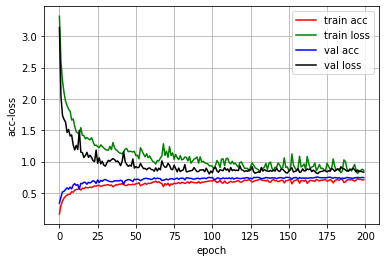

In [ ]:
train_acc = []
test_acc = []
for j in range(1, 11):
  model = Mario_CNN_plus(input_shape = (12, 10, 1), classes = 52, n_of_streams = j, dic=dic)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history = LossHistory()
  model.fit(data, label, validation_split=0.2, epochs=eps, batch_size=256, verbose=1, callbacks=[history])
  preds_train = model.evaluate(X_train, Y_train)
  print("Train Accuracy = " + str(preds_train[1]))
  train_acc.append(preds_train[1])
  preds_test  = model.evaluate(X_test, Y_test)
  print("Test Accuracy = " + str(preds_test[1]))
  test_acc.append(preds_test[1])
  history.loss_plot('epoch')

Text(0, 0.5, 'Accuracy')

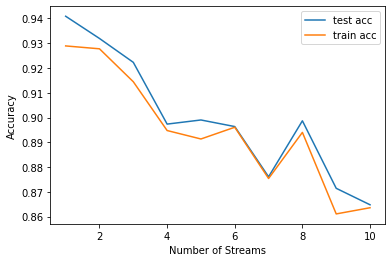

In [ ]:
plt.plot(np.arange(1,11), test_acc, label='test acc')
plt.plot(np.arange(1,11), train_acc, label='train acc')
plt.legend()
plt.xlabel('Number of Streams')
plt.ylabel('Accuracy')